# Regression in Recurrent Neural Networks using *Bayes-by-Backprop*

This notebook provides a demo for performing inference in BNNs using a RNN model, for the method of *Bayes-by-Backprop* from [Blundell et al. (2015)](https://arxiv.org/abs/1505.05424https://arxiv.org/abs/1505.05424).

## GPU support

This block is to disable GPU execution of TensorFlow. Depending on your system, enabling GPU may result in faster training.

*Comment this block to enable GPU execution*

In [1]:
# Disable GPU execution
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Packages

We import some standard packages as wel as TensorFlow and our own Bayesian TensorFlow package, make sure you have them installed prior!

In [2]:
# Import packages
import numpy as np
from tqdm.auto import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import bayesian_tensorflow as btf

## Setup

Below we set the experiment details for the demo, mostly concerning the specific dataset and the number of training epochs.

We have implemented two different reparameterizations for BBB, which we select using `reparam`.

We use a seed for reproducibility, but this can be ignored if preferred by setting it to `None`.

In [3]:
# Set hyperparameters
name       = 'sawtooth'
reparam    = 'local'        # 'local' or 'global'
n_epochs   =  5000
seed       =  60
batch_size =  16
seq_len    =  8
lr         =  1e-3

## Dataset

We have inlcuded the toy datasets used in our paper, which we have stored in the `dataset` folder.

You can load a specific dataset using the function `toy.load` and specifying the name of the dataset.

In [4]:
# Get custom datasets module
from datasets import toy

# Load dataset
(x, y) = toy.load(name=name)

We plot the data below.

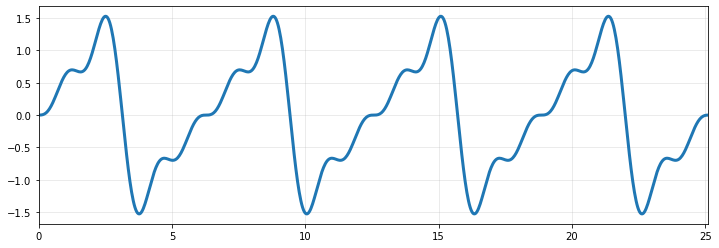

In [5]:
# Plot training data
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(x, y, lw=3)
ax.set_xlim([x[0], x[-1]])
ax.grid(linewidth=0.5, alpha=0.5);

We save the total number of data samples, as this is needed in the computation of the VFE loss.

In [6]:
# Total data size
n_data = tf.cast(tf.shape(x)[0], dtype=tf.float32)

We then set our seed for randomness and combine the data samples into a TensorFlow dataset.

In [7]:
# Set random seed
tf.random.set_seed(seed)

# Create TF-dataset
dataset = tf.keras.utils.timeseries_dataset_from_array(
    y, y[seq_len:],
    sequence_length=seq_len,
    batch_size=batch_size
)

## Model

We create the model using the `Sequential` model from TensorFlow, with our custom layers.

We specify the specific reparameterization using the `reparam` flag, this is either `local` or `global` (as a string).

We use the default `RNN` layer from TensorFlow to wrap our custom GRU layer to make it recurrent. Depending on your system, the `unroll=True` flag can speed up training.

In [8]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.RNN(btf.layers.GRUCellBBB(16, reparam=reparam, seed=seed), 
                        input_shape=(seq_len, 1), unroll=True),
    btf.layers.DenseBBB(1, reparam=reparam, seed=seed),
    btf.layers.GammaBBB(1),
])

__*You always need to add a Gamma layer to the end of the model!*__

This layers adds the gamma parameters into the model and allows for joint optimization.

In [9]:
# Overview of model
model.summary(line_length=75, positions=[0.55, 0.85, 1.0, 1.0])

Model: "sequential"
___________________________________________________________________________
 Layer (type)                            Output Shape          Param #     
 rnn (RNN)                               (None, 16)            1776        
                                                                           
 dense_bbb (DenseBBB)                    (None, 1)             34          
                                                                           
 gamma_bbb (GammaBBB)                    (None, 1, 3)          2           
                                                                           
Total params: 1,812
Trainable params: 1,764
Non-trainable params: 48
___________________________________________________________________________


## Training

We save the three separate terms of the VFE loss for evaluation of the training process.

In [10]:
# Variables to store training results
vfe_kl_theta = np.zeros(n_epochs)
vfe_kl_tau   = np.zeros(n_epochs)
vfe_acc_loss = np.zeros(n_epochs)

We use the `Adam` optimizer for the training.

In [11]:
# Create optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

We use a custom training loop with a progress bar for the training process.

The custom update step is included in `btf.inference.BBB`, which performs VFE minimization on mini-batches.

It also returns the three separate terms of the VFE loss.

In [12]:
# Custom training loop
for epoch in tqdm(range(n_epochs), desc='Training'):    
    
    # Iterate over training batches
    for x_batch, y_batch in dataset:
        
        # Perform training step
        kl_theta, kl_tau, acc_loss = \
            btf.inference.BBB(model, optim, x_batch, y_batch, n_data)
            
        # Add losses to total
        vfe_kl_theta[epoch] += kl_theta
        vfe_kl_tau[epoch]   += kl_tau
        vfe_acc_loss[epoch] += acc_loss

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

## Saving

We save the weights of the trained model for use in further experiments.

In [13]:
# Set save directory
save_dir = './models/BBB/' + name + '/' + reparam + '/weights'

# Save entire model
model.save_weights(save_dir)

## Evaluation

We can evaluate the VFE after training.

Since we are using a sampling-based approach, we set the number of MC-samples used for evaluation.

In [14]:
# Number of MC-samples
samples = 10

In order the have reproducible results, we reset the seed.

In [15]:
# Reset seed
tf.random.set_seed(seed)

We now evaluate the model for the whole dataset, using the number of MC-samples to get an average.

In [16]:
# Variables to store result
vfe_total = 0
    
# Iterate over data batches
for x_batch, y_batch in dataset:
    
    # Reset batch VFE
    vfe_batch = 0
    
    # Loop over runs
    for sample in range(samples):

        # Get VFE loss
        vfe_batch += btf.evaluation.BBB(model, x_batch, y_batch, n_data)
        
    # Add average VFE to total
    vfe_total += vfe_batch/samples
    
# Show final Variational Free Energy
print('Free Energy: ' + f'{vfe_total:.0f}')

Free Energy: -1035


## Predictions

After training we can generate predictions, including uncertainty.

In [17]:
# Empty matrix for results
pred = np.zeros((int(n_data-seq_len), samples))

# Reset seed
tf.random.set_seed(seed)

# Iterate over runs
for sample in range(samples):
    # Get outputs
    out = tf.squeeze(model.predict(dataset, verbose=0))
    # Split predictions
    pred[:,sample], _, _ = tf.unstack(out, 3, axis=-1)

# Get mean and variance
mu   = np.mean(pred, axis=1)
var  = np.var(pred, axis=1)

# Get gamma parameters
alpha = np.exp(model.layers[-1].get_weights()[0][0])
beta  = np.exp(model.layers[-1].get_weights()[1][0])

# Compute sigma
sigma = var + beta / alpha

We plot the resulting predictions below.

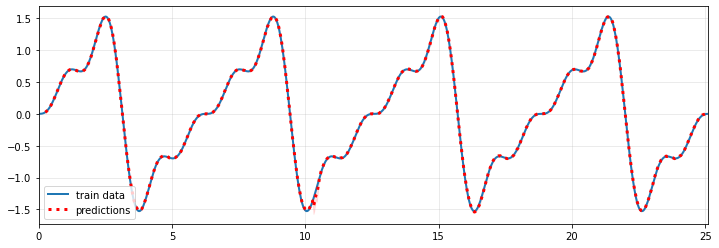

In [18]:
# Plot training data and predictions
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(x, y, lw=2, label='train data')
ax.plot(x[seq_len:], mu, lw=3, c='r',linestyle = ':', label='predictions')
ax.fill_between(x[seq_len:], mu-sigma, mu+sigma, color='r', alpha=0.1)
ax.legend(loc="lower left")
ax.set_xlim([x[0], x[-1]])
ax.grid(linewidth=0.5, alpha=0.5);

## Plots

Finally, we can plot the total VFE loss and its separate terms for the training duration.

This function is placed into a seperate folder of `figures`.

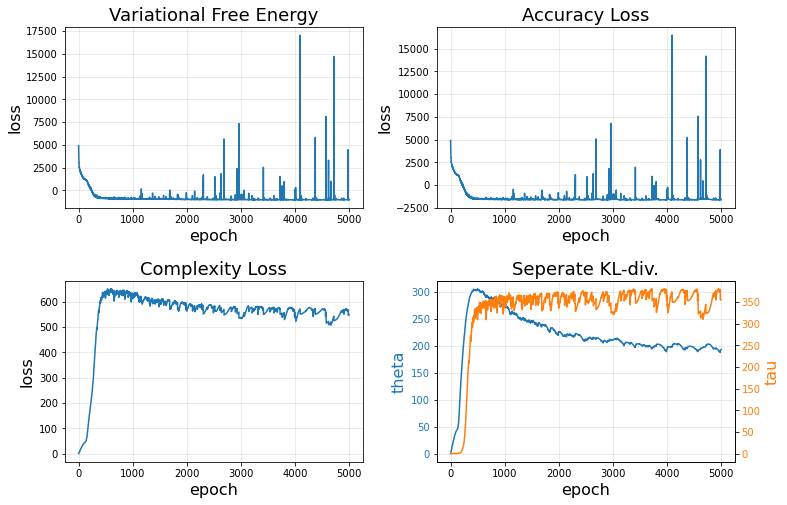

In [19]:
# Import local module
from figures import PlotTrainingLosses

# Plot training losses
PlotTrainingLosses(vfe_kl_theta, vfe_kl_tau, vfe_acc_loss)

## Post-hoc BMR

Compression using BMR is implemented for each layer. By default the variance of the reduced prior is set to $10^{-16}$.

You can call the compression method for each custom layer, using the `compress()` method.

In [20]:
# GRU layer, need to add `.cell`
model.layers[0].cell.compress()
# Dense layer
model.layers[1].compress()

We can now revaluate the VFE to see what the effect of post-hoc BMR has been.

In [21]:
# Reset seed
tf.random.set_seed(seed)

In [22]:
# Variables to store result
vfe_total = 0
    
# Iterate over data batches
for x_batch, y_batch in dataset:
    
    # Reset batch VFE
    vfe_batch = 0
    
    # Loop over runs
    for sample in range(samples):

        # Get VFE loss
        vfe_batch += btf.evaluation.BBB(model, x_batch, y_batch, n_data)
        
    # Add average VFE to total
    vfe_total += vfe_batch/samples
    
# Show final Variational Free Energy
print('Free Energy: ' + f'{vfe_total:.0f}')

Free Energy: -1147
